# SVM w praktyce

Zbiór WBreastCancer - przypomnienie

Zbiór <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29"><b>Breast Cancer Wisconsin (Diagnostic) Data Set</b></a> dotyczy klasyfikacji raka piersi jako złośliwego bądź łagodnego na podstawie pomiarów jąder komórkowych uzyskanych ze zdjęć pobranej masy.  

Dla każdego przypadku oprócz identyfikatora pacjenta oraz diagnozy podane są zmierzone wartości dotyczące jąder komórkowych. Mierzonych cech jest 10, natomiast dla każdej z nich podana jest najpierw wartość średnia, następnie wartość błędu standardowego, a na koniec najgorsza ze zmierzonych wartości, co daje w sumie 30 cech.  

Wszystkich przypadków jest 569

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [2]:
# podgląd danych

df_cancer = pd.DataFrame(data = np.concatenate((cancer['target'].reshape((569,1)),cancer['data']), axis=1), 
                         columns=np.concatenate((['diagnosis'], cancer['feature_names'])))
df_cancer.head()

,diagnosis,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


0.0 - nowotwór jest złośliwy

1.0 - nowotwór nie jest złośliwy

In [3]:
data_cancer_x = cancer['data']
data_cancer_y = cancer['target']

Wizualizacja danych - użycie PCA do przetransformowania danych z 30 wymiarów do dwóch:

In [4]:
# konieczna dla przeprowadzenia PCA standaryzacja danych:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_cancer_x)
scaled_data = scaler.transform(data_cancer_x) 

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

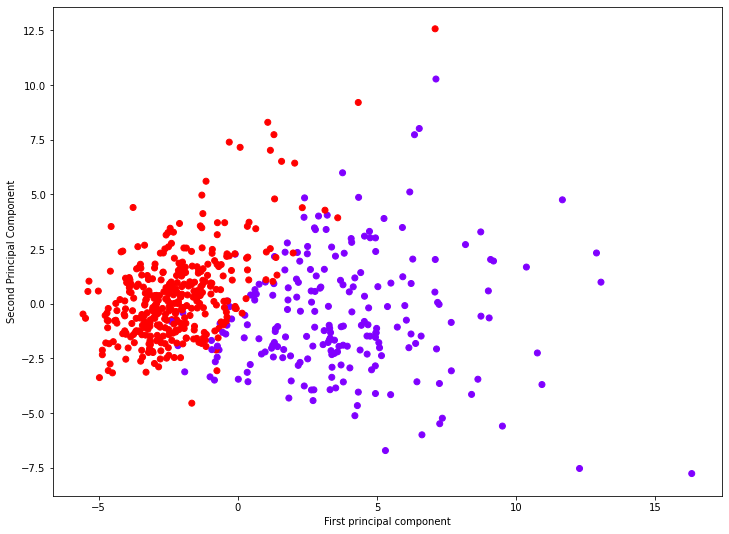

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,9))
plt.scatter(pca_data[:,0],pca_data[:,1],c=data_cancer_y,cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.show()

Pokażemy teraz działanie SVM, próbując rozdzielić dane uzyskane poprzez zastosowanie PCA za pomocą linii:

In [7]:
# przygotowanie danych - "1" dla złośliwych nowotworów, "-1" dla niezłośliwych

new_y = []
for val in data_cancer_y:
    if(val == 1.0):
        new_y.append(-1)
    else:
        new_y.append(1)
new_y = np.array(new_y)

In [8]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# tasowanie danych i rozdzielenie na training oraz test sets

X, y = shuffle(pca_data, new_y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
y_train = y_train.reshape((y_train.shape[0],1))
y_test = y_test.reshape(y_test.shape[0],1)

Funkcja, którą będziemy chcieli rozdzielić dane, ma postać y = wx + b.

Dla uproszczenia prezentacji matematyki stojącej za działaniem SVM, każda z wag w oraz bias b są osobnymi zmiennymi.

Używana przez nas funkcja straty - hinge loss - ma postać:

$ c(x,y,f(x)) = max(0, 1 - y * f(x)) $

Po dodaniu parametru lambda, odpowiadającego za regularyzację, funkcja kosztu ma postać:

min<sub>w</sub> &lambda; ||w||<sup>2</sup> + &sum;(1 - y<sub>i</sub> <x<sub>i</sub>, w>)<sub>+</sub>

Aby znaleźć gradient, należy policzyć pochodne cząstkowe funkcji kosztu względem wag. Mając obliczony gradient, można aktualizować wagi.

Więcej informacji: https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

In [9]:
# SVM

train_f0 = np.ones((x_train.shape[0], 1))
train_f1 = x_train[:,0]
train_f2 = x_train[:,1]

train_f1 = train_f1.reshape(train_f1.shape[0],1)
train_f2 = train_f2.reshape(train_f2.shape[0],1)

b = 0
w1 = 0
w2 = 0

epochs = 1
alpha = 0.0001

while(epochs < 1000):
    y = w1 * train_f1 + w2 * train_f2 + b * train_f0  # obliczamy wartość funkcji y
    prod = y * y_train  # sprawdzenie poprawności klasyfikacji - potrzebne do określenia wartości funkcji hinge loss
    print(epochs)
    count = 0
    for val in prod: # określanie wartości funkcji hinge loss, aktualizacja parametrów
        if(val >= 1):
            cost = 0
            # w = w - alpha * (2 * lambda * w) - poprawna klasyfikacja, aktualizacja wag ze względu na 
            # gradient regularyzacji
            b = b - alpha * (2 * 1/epochs * b)
            w1 = w1 - alpha * (2 * 1/epochs * w1)
            w2 = w2 - alpha * (2 * 1/epochs * w2)
            
        else:
            cost = 1 - val 
            # w = w + alpha * (x_i * y_i - 2 * lambda * w) - niepoprawna klasyfikacja, 
            # uwzględnienie również gradientu funkcji straty
            b = b + alpha * (train_f0[count] * y_train[count] - 2 * 1/epochs * b)
            w1 = w1 + alpha * (train_f1[count] * y_train[count] - 2 * 1/epochs * w1)
            w2 = w2 + alpha * (train_f2[count] * y_train[count] - 2 * 1/epochs * w2)

        count += 1
    epochs += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Jak można zauważyć, w powyższym kodzie alpha pełni funkcję learning rate, natomiast wartość parametru lambda jest ustawiona na 1/epochs (a więc maleje w miarę wzrostu liczby epok).

Sprawdźmy teraz, jak nasz wytrenowany klasyfikator poradzi sobie ze zbiorem testowym:

In [10]:
from sklearn.metrics import accuracy_score

test_f0 = np.ones((x_test.shape[0], 1))
test_f1 = x_test[:,0]
test_f2 = x_test[:,1]

test_f1 = test_f1.reshape(x_test.shape[0],1)
test_f2 = test_f2.reshape(x_test.shape[0],1)

# Predykcja
y_pred = w1 * test_f1 + w2 * test_f2 + b * test_f0
predictions = []
for val in y_pred:
    if(val > 1):
        predictions.append(1)
    else:
        predictions.append(-1)

print(accuracy_score(y_test,predictions))

0.9473684210526315


Oczywiście, można również wykorzystać gotowe implementacje SVM. Można w tym celu użyć scikit-learn:

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

y_train = y_train.reshape((y_train.shape[0],))
clf = SVC(kernel='linear', )
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.9473684210526315


Sprawdźmy teraz, jak poradzi sobie SVM dla danych bez PCA:

In [12]:
X, y = shuffle(data_cancer_x, data_cancer_y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [13]:
y_train = y_train.reshape((y_train.shape[0],))
clf = SVC(kernel='linear', )
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.9649122807017544


sklearn.svm.SVC pozwala na dobieranie kernela oraz parametrów uczenia.

Możliwe kernele to: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ albo kernel stworzony przez siebie.

Najważniejsze parametry uczenia, których wartości można dobierać, to:
- C: parametr służący do regularyzacji, proporcjonalny do 1/lambda. Musi być liczbą dodatnią (default=1.0)
- degree: stopień wielomianu (przy użyciu kernela 'poly')
- gamma: współczynnik dla kerneli 'rbf', 'poly', 'sigmoid' ze zbioru {'scale', 'auto'} albo float (default='scale')
- coef0: wartość "r" dla kerneli 'poly' i 'sigmoid', float (default=0.0)

(szczegóły: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html )

Prześledźmy użycie SVM dla zbioru MNIST oraz różnych kerneli i wartości parametrów C:


In [14]:
import tensorflow as tf
from sklearn.utils import resample

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, y_train = resample(x_train, y_train, n_samples=500, replace=False, random_state=0)
x_test, y_test = resample(x_test, y_test, n_samples=100, replace=False, random_state=0)
x_train = x_train.reshape((x_train.shape[0],-1))
x_test = x_test.reshape((x_test.shape[0],-1))

In [15]:
from sklearn.preprocessing import StandardScaler

scaler_mnist = StandardScaler().fit(x_train)
x_train = scaler_mnist.transform(x_train)
x_test = scaler_mnist.transform(x_test)

In [16]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        clf = SVC(C=C, kernel=kernel, )
        clf.fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        score = accuracy_score(y_test, y_pred)
        print('kernel=%s, C=%f, score=%f' %(kernel, C, score))

kernel=linear, C=0.001000, score=0.830000
kernel=linear, C=0.010000, score=0.780000
kernel=linear, C=0.100000, score=0.800000
kernel=linear, C=1.000000, score=0.800000
kernel=linear, C=10.000000, score=0.800000
kernel=linear, C=100.000000, score=0.800000
kernel=linear, C=1000.000000, score=0.800000
kernel=poly, C=0.001000, score=0.110000
kernel=poly, C=0.010000, score=0.110000
kernel=poly, C=0.100000, score=0.140000
kernel=poly, C=1.000000, score=0.380000
kernel=poly, C=10.000000, score=0.720000
kernel=poly, C=100.000000, score=0.740000
kernel=poly, C=1000.000000, score=0.740000
kernel=rbf, C=0.001000, score=0.100000
kernel=rbf, C=0.010000, score=0.100000
kernel=rbf, C=0.100000, score=0.390000
kernel=rbf, C=1.000000, score=0.810000
kernel=rbf, C=10.000000, score=0.810000
kernel=rbf, C=100.000000, score=0.810000
kernel=rbf, C=1000.000000, score=0.810000
kernel=sigmoid, C=0.001000, score=0.100000
kernel=sigmoid, C=0.010000, score=0.100000
kernel=sigmoid, C=0.100000, score=0.650000
kernel

## Zadanie:

Na podstawie powyższych eksperymentów, dobierz odpowiedni kernel i parametry uczenia dla wybranego przez siebie zbioru danych. Nie ograniczaj się przy tym wyłącznie do dobierania wartości C, poeksperymentuj również z parametrami charakterystycznymi dla odpowiednich kerneli.

In [17]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [18]:
from sklearn.utils import resample
x_train, y_train = resample(x_train, y_train, n_samples=500, replace=False, random_state=0)
x_test, y_test = resample(x_test, y_test, n_samples=100, replace=False, random_state=0)
x_train = x_train.reshape((x_train.shape[0],-1))
x_test = x_test.reshape((x_test.shape[0],-1))

In [19]:
from sklearn.preprocessing import StandardScaler

scaler_mnist = StandardScaler().fit(x_train)
x_train = scaler_mnist.transform(x_train)
x_test = scaler_mnist.transform(x_test)

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

kernel = 'poly'
C = 1
degree = 5
gamma = 'scale'
coef0 = 1.0
clf = SVC(C = C, kernel = kernel, degree = degree, gamma = gamma, coef0 = coef0)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
score = accuracy_score(y_test, y_pred)
print('kernel=%s, C=%f, score=%f' %(kernel, C, score))

kernel=poly, C=1.000000, score=0.830000


# Walidacja klasyfikacji

Podczas ewaluacji różnych ustawień hiperparametrów dla estymatorów, takich jak ustawienie *C* które musi zostać manualnie ustawione dla SVM, istnieje ryzyko **overfittingu** na zbiorze testowym, ponieważ parametry mogą być modyfikowane dopóki estymator nie będzie zachowywał się optymalnie. 
Poprzez to, wiedza o modelu testowym może "przedostać" się do modelu. W taki sposób model "dopasowuje" się do konretnego zbioru testowego. 
Aby uniknąć takiego problemu dane można podzielić na zbiór treningowy, testowy oraz walidacyny. 
* Trenowanie modelu odbywa się na **zbiorze treningowym**.
* Po wytrenowaniu modelu wykonywana jest ewaluacja na **zbiorze walidacyjnym**, aby ostateczne hiperparametry wybrać w oparciu o wynik na zbiorze walidacyjnym.
* Ostatecznie odbywa się ewaluacja na **zbiorze testowym**, wówczas wynik na zbiorze testowym daje wiarygodne oszacowanie jakości modelu dla nowych danych.  

### Podsumowując:
**Zbiór wlidacyjny** - służy do wyboru hiperparametrów, stosowany aby uniknąć dopasowania modelu do danych testowych  
**Zbiór testowy** - służy do testowania jakości modelu

## Cross Validation

Dzieląc dane na trzy zestway, drestycznie zmiejszamy liczbę próbek, które możemy wykorzystać do nauki modelu, a wyniki mogą zależeć od losowego wyboru zbioru treningowego i walidacyjnego.  Roziązaniem tego problemu jest **cross-validation** (w skrócie CV). Zestaw testowy powinien być trzymany do ostatecznej oceny modelu, natomiast zestaw walidacyjny nie jest potrzebny gdy użyjemy CV.  
W podstawowym podejściu zwanym **k-fold CV**, zestaw treningowy jest dzielony na *k* mniejszych zestawów.  
Następnie k-krotnie stosuje się procedurę:  
* Trenujemy model przy wykorzystaniu *k-1* mniejszych zestawów danych.

Wynikowy model jest sprawdzany na danych treningowych. 

W skrócie:  
**cross-validation** - umożliwienia przeprowadznenie walidacji bez wyodrębnionego zbioru walidacyjnego.

Najprostszym użyciem cross-validation jest funkcja **cross_val_score**.  
  
Jako wynik otrzymujemy tablicę z wynikami precyzji, wyniki są dla każdego podzialu danych (dla każdego k).  
  
W ***cross_val_score*** możemy stosować różne miary precyzji estymatora. Aby zastosować daną miarę precyzji należy użyć dodatkowy parametr ***scoring***. Domyślną miarą precyzji jest *accuracy*.

In [21]:
from sklearn.model_selection import cross_val_score

In [22]:
X, y = shuffle(data_cancer_x, data_cancer_y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
y_train = y_train.reshape((y_train.shape[0],))
clf = SVC(kernel='linear')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

Dla przykładu, wyznaczamy wartości *accuracy* dopasowanego modelu w 5-krotnej cross-walidacji.

In [23]:
accuracy = cross_val_score(clf, x_train, y_train, cv=5)
accuracy

array([0.95145631, 0.94174757, 0.95098039, 0.96078431, 0.96078431])

### Accuracy

**Accuracy** - jest to najprostszy wynik jakości klasyfikacji
  
$accuracy = \frac{M}{N},$
  
Gdzie:  
M - ilość dobrze sklasyfikowanych próbek  
N - ilość wszystkich próbek  

Przykład:

In [24]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score: {0:0.2f}'.format(accuracy)) 

Accuracy score: 0.93


## Loss

Log loss nazywane równie regresją logarytmiczną lub cross-entropy loss, jest zdefiniowania na podstawie oszacowań prawdopodobieństwa. Jest powszechnie używana w sieciach neuronowych, może być używana do oceny wyników prawdopodobieństwa (predict_proba) klasyfikatora zamiast jego prognoz.

W przypadku klasyfikacji binarnej z prawdziwą etykietą $ y \in {0,1} $ i oszacowaniem prawdopodobieństwa $ p = \operatorname{Pr} (y = 1) $, wówczas log loss:

$L_{\log}(y, p) = -\log \operatorname{Pr}(y|p) = -(y \log (p) + (1 - y) \log (1 - p))$

W przypadku wieloklasowym:
Niech prawdziwe etykiety danych będą zakodowane jako macierz binarna 1-of-K $ Y $, tj. $ y_{i, k} = 1 $, jeśli próbka $i$ ma etykietę $k$ pobraną z zestawu etykiet $K$. Niech $P$ będzie macierzą oszacowań prawdopodobieństwa, przy czym $ p_{i, k} = \operatorname {Pr} (t_ {i, k} = 1) $. Wówczas log loss: 

$L_{\log}(Y, P) = -\log \operatorname{Pr}(Y|P) = - \frac{1}{N} \sum_{i=0}^{N-1} \sum_{k=0}^{K-1} y_{i,k} \log p_{i,k}$


Aby zobaczyć, w jaki sposób uogólnia to binary log loss podaną powyżej, zauważ, że w przypadku binarnym $p_{i,0} = 1 - p_{i,1}$  and $y_{i,0} = 1 - y_{i,1}$, więc powiększenie wewnętrznej sumy o $y_{i,k} \in \{0,1\}$ powoduje binary log loss.

Funkcja *log_loss* oblicza log loss, biorąc pod uwagę listę ground-truth labels i macierz prawdopodobieństwa, zwrócone przez metodę prognostyczną estymatora.


Prościej mówiąc:  
Log loss mierzy wydajność klasyfikatora, w którym dane wejściowe są wartością prawdopodobieństwa między 0 a 1. Celem modeli jest zminimalizowanie tej wartości. Idealny model miałby log loss równy 0. Log loss wzrasta, gdy przewidywane prawdopodobieństwo odbiega od rzeczywistej etykiety. Zatem przewidywanie prawdopodobieństwa 0.012, gdy rzeczywista etykieta obserwacji wynosi 1, byłoby złe i spowodowałoby wysoki log loss. 


In [25]:
from sklearn.metrics import log_loss
loss = log_loss(y_test,y_pred)
print('Loss score: {0:0.2f}'.format(loss)) 

Loss score: 2.42


## Precision/recall

Niedoskonałością miary jakości *accuracy* są niezrównoważone klasy. Jeśli jedna z klas stanowi zdecydowaną więkoszość np. 90% wszystkich przypadków, to estymator który zawsze będzie zwracał tą klasę osiągnie dokładność 0.90. 

Rozwiązaniem problemu jest miara *precision* i *recall*:  

$precision = \frac{\#TP}{\#TP + \#FP},$

$recall = \frac{\#TP}{\#TP + \#FN},$

gdzie:
 - TP - *true positives* (klasy które zostały dobrze sklasyfikowane)
 - FP - *false positives* (klasy 0 sklasyfikowane jako 1)
 - FN - *false negatives* (klasy 1 sklasyfikowane jako 0)


In [26]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred)
print('Precision-recall score: {0:0.2f}'.format(average_precision))

Precision-recall score: 0.92


## F1

F1 jest przydatne gdy chcemy zbalansować różnice pomiędzy Precision and Recall. Można to interpretować jako śrenią ważoną precision and recall, gdzie wynik F1 osiąga najlepszą wartośc przy 1 a najgorszą przy 0. Względny wkład w wynik F1 dla precision oraz recall jest równy:  
  
$F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$

Podsumowując F1 służy do zbalansowania Precision and Recall.

In [27]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test,y_pred)
print('F1 score: {0:0.2f}'.format(average_precision))

F1 score: 0.92


## Krzywa Precision/Recall

Krzywą precision-recall wykreślamy dla danej klasy. Podobnie jak liczymy precision i recall dla klasy. Domyślnie w większości bibliotek rysowana jest dla klasy pozytywnej. Na osi X odkładamy policzone wartości recall a na osi Y precision.  

### Interpretacja krzywej precision-recall

Zacznijmy od przypadku najgorszego. Niech nasz klasyfikator działa losowo. Gdy stosunek klas pozytywnej do negatywnej wynosi 1:1 to wykres będzie przebiegał mniej więcej na wysokości 0.5 (50% szans trafienia poprawnej klasy).  
  
W przypaku idealnym precision dla różnych wartości recall powinno wynosić 1. Zwiększając kolejno próg będziemy otrzymywać poprawne rozpoznanie, jedyne co będzie się zmieniać to recall, będzie się ono zmniejszać

### Tworzenie krzywej precision-recall

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.92')

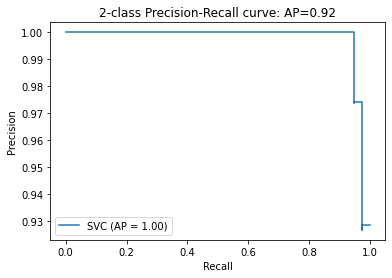

In [28]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(clf, x_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

## Krzywa ROC

Krzywa ROC jest to kolejny ze sposobów wizualizacji jakości klasyfikacji, pokazujący zależności wskaźników TPR (True Positive Rate) oraz FPR (False Positive Rate).

### Interpretacja krzywej ROC

Jakość klasyfikacji za pomocą krzywej ROC można ocenić wyliczając takie wskaźniki jak:

* **Pole pod krzywą (AUC)**

Im większe AUC tym lepiej: 
* AUC = 1 (klasyfikator idealny), 
* AUC = 0.5 (klasyfikator losowy), 
* AUC < 0.5 (nieprawidłowy klasyfikator (gorszy niż losowy)).
  
Upraszczając: 
Im wykres bardziej ”wypukły”, tym lepszy klasyfikator. 

### Tworzenie krzywej ROC

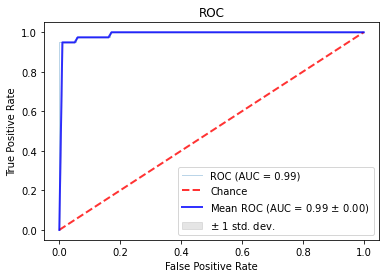

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from numpy import interp

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()

viz = plot_roc_curve(clf, x_test, y_test,
                         name='ROC',
                         alpha=0.3, lw=1, ax=ax)

interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
interp_tpr[0] = 0.0
tprs.append(interp_tpr)
aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC")
ax.legend(loc="lower right")
plt.show()

# Zadania

a) Na zbiorach MNIST, FMNIST, TNG (twenty news groups) zaprezentować działanie
klasyfikatora SVM i wyniki porównać do klasyfikatora k-NN przy pomocy poznanych miar
walidacji klasyfikacji. (dla najlepszej konfiguracji, stałej uczenia, funkcji kernela)

b) Zaproponować, taką augmentację zbiorów treningowych (wielkość zbioru zależna od
mocy obliczeniowej którą Państwo dysponują) aby uzyskać jak najlepsze miary jakości na
zbiorach testowych.

a)

In [278]:
def SVM_analyze(x_train,y_train,x_test,y_test):
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score
    
    arrC=[0.01, 0.1, 1.0, 10.0, 100.0]

    kernelArr=[]
    supportArrC=[]
    arrDegree=[]
    arrScore=[]
    arrCoef0=[]
    
    for C in arrC:
        clf = SVC(C=C, kernel='linear')
        clf.fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        score = accuracy_score(y_test, y_pred)
        kernelArr.append("linear")
        supportArrC.append(C)
        arrDegree.append("")
        arrScore.append(score)
        arrCoef0.append("")        
#         print('kernel=linear, C=%f, score=%f' %(C, score))


    for C in arrC:
        for degree in [2,3,4]:
            clf = SVC(C=C, kernel='poly', degree=degree)
            clf.fit(x_train,y_train)
            y_pred = clf.predict(x_test)
            score = accuracy_score(y_test, y_pred)
            kernelArr.append("poly")
            supportArrC.append(C)
            arrDegree.append(degree)
            arrScore.append(score)
            arrCoef0.append("")
#             print('kernel=poly, C=%f, degree=%d, score=%f' %(C, degree, score))
            

    for C in arrC:
        for coef0 in [0.0,0.5,1.0]:
            clf = SVC(C=C, kernel='sigmoid', coef0=coef0)
            clf.fit(x_train,y_train)
            y_pred = clf.predict(x_test)
            score = accuracy_score(y_test, y_pred)
            kernelArr.append("sigmoid")
            supportArrC.append(C)
            arrDegree.append("")
            arrScore.append(score)
            arrCoef0.append(coef0)
#             print('kernel=sigmoid, C=%f, coef0=%f, score=%f' %(C, coef0, score))

    dataframe=pd.DataFrame({"C":supportArrC,"degree":arrDegree,"coef0":arrCoef0,"score":arrScore,"kernel":kernelArr})
    
    return dataframe.style.apply(lambda x: ["background: red" if v == x.max() else "" for v in x], axis = 0, subset="score")

In [279]:
svmAcc=[]
svmF1=[]
knnAcc=[]
knnF1=[]

# MNIST

In [280]:
import tensorflow as tf
from sklearn.utils import resample
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)

x_train, y_train = resample(x_train, y_train, n_samples=600, replace=False, random_state=0)
x_test, y_test = resample(x_test, y_test, n_samples=400, replace=False, random_state=0)

In [281]:
#SVM
mnist_df=SVM_analyze(x_train,y_train,x_test,y_test)
mnist_df

,C,degree,coef0,score,kernel
0,0.010000,,,0.850000,linear
1,0.100000,,,0.850000,linear
2,1.000000,,,0.850000,linear
3,10.000000,,,0.850000,linear
4,100.000000,,,0.850000,linear
5,0.010000,2,,0.112500,poly
6,0.010000,3,,0.120000,poly
7,0.010000,4,,0.127500,poly
8,0.100000,2,,0.662500,poly
9,0.100000,3,,0.515000,poly


In [282]:
#accuracy
C=1.0
clf = SVC(C=C, kernel='poly', degree=2)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
score = accuracy_score(y_test, y_pred)
print('kernel=linear, C=%f, score=%f' %(C, score))
svmAcc.append(score)

kernel=linear, C=1.000000, score=0.862500


In [283]:
#f1
from sklearn.metrics import f1_score
f1_score(y_true=y_test, y_pred=y_pred, average=None)


array([0.91666667, 0.86956522, 0.83076923, 0.88888889, 0.90598291,
       0.73076923, 0.91891892, 0.83146067, 0.85714286, 0.81081081])

In [284]:
mean_score=np.mean(f1_score(y_true=y_test, y_pred=y_pred, average=None))
svmF1.append(mean_score)

In [285]:
#k-nn - accuracy
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3, algorithm='auto')
neigh.fit(x_train, y_train)

y_pred_knn = neigh.predict(x_test)
acc_score=accuracy_score(y_true=y_test, y_pred=y_pred_knn)
knnAcc.append(acc_score)

In [286]:
#f1
f1_score(y_true=y_test, y_pred=y_pred_knn, average=None)

array([0.94444444, 0.81632653, 0.85245902, 0.83544304, 0.82758621,
       0.65306122, 0.89411765, 0.85365854, 0.76315789, 0.7804878 ])

In [287]:
mean_score=np.mean(f1_score(y_true=y_test, y_pred=y_pred_knn, average=None))
knnF1.append(mean_score)

# FMNIST

In [288]:
import tensorflow as tf
from sklearn.utils import resample
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)

x_train, y_train = resample(x_train, y_train, n_samples=600, replace=False, random_state=0)
x_test, y_test = resample(x_test, y_test, n_samples=100, replace=False, random_state=0)

In [289]:
#SVM
fmnist_df=SVM_analyze(x_train,y_train,x_test,y_test)
fmnist_df

,C,degree,coef0,score,kernel
0,0.010000,,,0.820000,linear
1,0.100000,,,0.820000,linear
2,1.000000,,,0.820000,linear
3,10.000000,,,0.820000,linear
4,100.000000,,,0.820000,linear
5,0.010000,2,,0.320000,poly
6,0.010000,3,,0.420000,poly
7,0.010000,4,,0.460000,poly
8,0.100000,2,,0.610000,poly
9,0.100000,3,,0.630000,poly


In [290]:
#accuracy
C=1.0
clf = SVC(C=C, kernel='linear', degree=2)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
score = accuracy_score(y_test, y_pred)
print('kernel=linear, C=%f, score=%f' %(C, score))
svmAcc.append(score)

kernel=linear, C=1.000000, score=0.820000


In [291]:
#f1
from sklearn.metrics import f1_score
import numpy as np
f1_score(y_true=y_test, y_pred=y_pred, average=None)

array([0.8       , 1.        , 0.88888889, 0.88888889, 0.75      ,
       0.72      , 0.69565217, 0.71428571, 0.84848485, 0.95238095])

In [292]:
mean_score=np.mean(f1_score(y_true=y_test, y_pred=y_pred, average=None))
svmF1.append(mean_score)

In [293]:
#k-nn - accuracy
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3, algorithm='auto')
neigh.fit(x_train, y_train)

y_pred_knn = neigh.predict(x_test)
knn_score=accuracy_score(y_true=y_test, y_pred=y_pred_knn)
knnAcc.append(knn_score)

In [294]:
#f1
f1_score(y_true=y_test, y_pred=y_pred_knn, average=None)

array([0.61538462, 0.83333333, 0.57142857, 0.77777778, 0.70588235,
       0.63157895, 0.66666667, 0.94117647, 0.96551724, 0.86956522])

In [295]:
mean_score=np.mean(f1_score(y_true=y_test, y_pred=y_pred_knn, average=None))
knnF1.append(mean_score)

# TNG

In [296]:
from sklearn.datasets import fetch_20newsgroups_vectorized
newsgroups_train = fetch_20newsgroups_vectorized(subset='train')

In [297]:
newsgroups_train
news_x = newsgroups_train.data
news_y = newsgroups_train.target

In [298]:
news_x.shape

(11314, 130107)

In [299]:
news_x.nnz/news_x.shape[0]

157.9958458546933

In [300]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=500, n_iter=7, random_state=0)
svd.fit(news_x)
svd_x = svd.transform(news_x)

In [301]:
svd_x.shape

(11314, 500)

In [302]:
x, y = resample(svd_x, news_y, n_samples=1000, replace=False, random_state=0)

In [303]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size=0.4, random_state=0 )

In [304]:
#SVM
tng_df=SVM_analyze(x_train,y_train,x_test,y_test)
tng_df

,C,degree,coef0,score,kernel
0,0.010000,,,0.060000,linear
1,0.100000,,,0.060000,linear
2,1.000000,,,0.320000,linear
3,10.000000,,,0.532500,linear
4,100.000000,,,0.540000,linear
5,0.010000,2,,0.060000,poly
6,0.010000,3,,0.060000,poly
7,0.010000,4,,0.060000,poly
8,0.100000,2,,0.065000,poly
9,0.100000,3,,0.065000,poly


In [305]:
C=100.0
clf = SVC(C=C, kernel='linear')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
score = accuracy_score(y_test, y_pred)
print('kernel=linear, C=%f, score=%f' %(C, score))
svmAcc.append(score)

kernel=linear, C=100.000000, score=0.540000


In [306]:
#f1
from sklearn.metrics import f1_score
import numpy as np
f1_score(y_true=y_test, y_pred=y_pred, average=None)

array([0.3030303 , 0.31111111, 0.59459459, 0.2       , 0.45      ,
       0.53846154, 0.53658537, 0.53061224, 0.66666667, 0.68965517,
       0.8       , 0.6       , 0.38095238, 0.57142857, 0.54545455,
       0.55555556, 0.53333333, 0.8       , 0.35714286, 0.58064516])

In [307]:
mean_score=np.mean(f1_score(y_true=y_test, y_pred=y_pred, average=None))
svmF1.append(mean_score)

In [308]:
#k-nn - accuracy
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3, algorithm='auto')
neigh.fit(x_train, y_train)

y_pred_knn = neigh.predict(x_test)
score=accuracy_score(y_true=y_test, y_pred=y_pred_knn)
knnAcc.append(score)

In [309]:
#f1
f1_score(y_true=y_test, y_pred=y_pred_knn, average=None)

array([0.21875   , 0.24242424, 0.28571429, 0.11764706, 0.33333333,
       0.16216216, 0.33333333, 0.22222222, 0.19047619, 0.31818182,
       0.45      , 0.34782609, 0.30769231, 0.32142857, 0.27272727,
       0.20689655, 0.23076923, 0.4137931 , 0.1875    , 0.28571429])

In [310]:
mean_score=np.mean(f1_score(y_true=y_test, y_pred=y_pred_knn, average=None))
knnF1.append(mean_score)

In [311]:
dataSets=["Mnist","Fmnist","TNG"]
dataframe=pd.DataFrame({"svm acc":svmAcc,"knn acc":knnAcc,"svm avg f1":svmF1,"knn avg f1":knnF1,"set":dataSets})

In [321]:
dataframe

,svm acc,knn acc,svm avg f1,knn avg f1,set
0,0.8625,0.8275,0.856098,0.822074,Mnist
1,0.8200,0.7600,0.825858,0.757831,Fmnist
2,0.5400,0.2725,0.527261,0.272430,TNG


# b) MNIST

In [312]:
import tensorflow as tf
from sklearn.utils import resample
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test = x_test.reshape(x_test.shape[0],-1)

x_train, y_train = resample(x_train, y_train, n_samples=600, replace=False, random_state=0)
x_test, y_test = resample(x_test, y_test, n_samples=400, replace=False, random_state=0)

In [313]:
x_train.shape

(600, 28, 28)

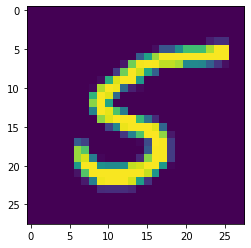

In [314]:
import matplotlib.pyplot as plt
plt.imshow(x_train[10])

In [315]:
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np

N = 100

def augment(images):
    seq = iaa.Sequential(
        [
            iaa.Crop(px=(1, 2), keep_size=True),
            iaa.SomeOf((0, 3),
                [
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        rotate=(-20, 20),
                        order=[0, 1],
                        cval=(0, 255),
                        mode=ia.ALL,
                    ),
                    iaa.GaussianBlur((0, 0.5)),
                    iaa.SaltAndPepper(0.05),
                ],
                random_order=True
            )
        ]
    )

    imagesX = images[:, :, :, np.newaxis]
    images_aug = seq(images=imagesX)
    return [np.squeeze(img) for img in images_aug]

In [316]:
aug_x = augment(x_train)

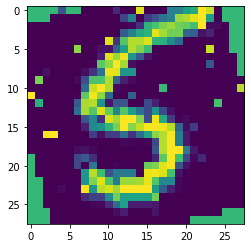

In [317]:
plt.imshow(aug_x[10])

In [318]:
x_train_notaug = x_train.reshape(x_train.shape[0],-1)
x_train_aug =np.array(aug_x).reshape(x_train.shape[0],-1)

x_train_aug = np.concatenate((x_train_notaug, x_train_aug))
y_train_aug = np.concatenate((y_train, y_train))

In [319]:
SVM_analyze(x_train_aug,y_train_aug,x_test,y_test)        

,C,degree,coef0,score,kernel
0,0.010000,,,0.850000,linear
1,0.100000,,,0.850000,linear
2,1.000000,,,0.850000,linear
3,10.000000,,,0.850000,linear
4,100.000000,,,0.850000,linear
5,0.010000,2,,0.137500,poly
6,0.010000,3,,0.145000,poly
7,0.010000,4,,0.157500,poly
8,0.100000,2,,0.717500,poly
9,0.100000,3,,0.605000,poly


In [320]:
SVM_analyze(x_train_notaug,y_train,x_test,y_test)

,C,degree,coef0,score,kernel
0,0.010000,,,0.850000,linear
1,0.100000,,,0.850000,linear
2,1.000000,,,0.850000,linear
3,10.000000,,,0.850000,linear
4,100.000000,,,0.850000,linear
5,0.010000,2,,0.112500,poly
6,0.010000,3,,0.120000,poly
7,0.010000,4,,0.127500,poly
8,0.100000,2,,0.662500,poly
9,0.100000,3,,0.515000,poly
